# Element Parameter Detection

## Setup

In [1]:
import numpy as np
import math
import random
import os
import os.path
import torch
import sys
import copy
import pickle
import importlib
import torch.nn as nn
import time
import functorch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from chamferdist import ChamferDistance
from pathlib import Path

import ifcopenshell
import open3d as o3d

from src.elements import *
from src.ifc import *
from src. preparation import *
from src.dataset import *
from src.pointnet import *
from src.visualisation import *
from src.geometry import sq_distance
from src.icp import icp_finetuning
from src.chamfer import *
from src.utils import *
from src.plots import plot_error_graph, plot_parameter_errors
from src.pca import testset_PCA
from src.finetune import chamfer_fine_tune
from tqdm.notebook import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
random.seed = 42

In [3]:
#path = Path("ModelNet10")
#path = Path('/content/drive/MyDrive/ElementNet/')
path = Path('output/')
#savepath = '/content/drive/MyDrive/ElementNet/'
savepath = 'models/'
cuda = torch.device('cuda')

## Model

## Test

Analyze results statistically

POINTNET++

In [4]:
train_transforms = transforms.Compose([
                    Normalize(),
#                    RandomNoise(),
                    ToTensor()
                    ])

In [44]:
# load data and model
BASE_DIR = os.path.dirname(os.path.abspath('industrial-facility-relationships/'))
BASE_DIR = os.path.join(BASE_DIR, 'pointnet2')
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'models'))

inference = True
cloi = True

if inference:
    if cloi:
        path = Path('cloi/')
        ext = ".pcd"       
    else:    
    #     path = Path('output/bp_data/')
        path = Path('output/east_ref/')
        #path = Path('/mnt/c/data/3D_CAD/east_clouds/')
        ext = ".pcd"
    
else:
    path = Path('output/')
    ext = ".pcd"

cat= 'elbow'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_normals = False
cat_targets = {"elbow":14, "bend":14, "tee":19, "pipe":11, "flange":13}

if inference:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms, inference=True)
    targets = cat_targets[cat]
else:
    test_ds = PointCloudData(path, valid=True, folder='test', category=cat, transform=train_transforms)
    targets = test_ds.targets

testDataLoader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=32)
test_criterion = nn.MSELoss()

model_name = "pointnet2_cls_ssg"
model_path = Path("pointnet2/log/classification/pointnet2_cls_ssg/")
model = importlib.import_module(model_name)


predictor = model.get_model(targets, normal_channel=use_normals)
if device != "cpu":
    predictor = predictor.cuda()

#checkpoint = torch.load(model_path/'checkpoints/best_model.pth')
checkpoint = torch.load(model_path/'checkpoints/models/best_model_e_chamfer_0005.pth')
#checkpoint = torch.load(model_path/'checkpoints/models/best_model_t_chamfer_00005_bp.pth')
predictor.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [45]:
blueprint = 'data/sample.ifc'
temp_dir = "output/temp/"
target_dir = "output/tee/test/"

ifcConvert_executable = "scripts/./IfcConvert"
cloudCompare_executable = "cloudcompare.CloudCompare"
sample_size = 2048
threshold = 2

In [46]:
def model_inference(model, loader, device, calculate_score=False):
    predictor = model.eval()
    predictions_list, pcd_list, id_list = [], [], []
    with torch.no_grad():
        for j, data  in tqdm(enumerate(loader), total=len(loader)):
            points, ids = data['pointcloud'].to(device).float(), data['id'].to(device)
            points = points.transpose(2, 1)
            preds, _ = predictor(points)
            preds, points, ids = preds.to(torch.device('cpu')), points.to(torch.device('cpu')), data['id'].to(torch.device('cpu'))
            for i, pr in enumerate(preds):
                predictions_list.append(pr.numpy())
                pcd_list.append(points[i].numpy())
                id_list.append(ids[i].numpy())

        return (predictions_list, pcd_list, id_list)

In [47]:
if inference:
    predictions_list, cloud_list, id_list = model_inference(predictor.eval(), testDataLoader, device)

  0%|          | 0/11 [00:00<?, ?it/s]

In [48]:
def test(model, loader, device, criterion):
    losses = []
    predictor = model.eval()
    cloud_list = []
    label_list = []
    output_list = []
    predictions_list = []
    inputs_list = []
    id_list = []
    parameter_id = 0
    tot = 0
    count = 0
    
    for j, data  in tqdm(enumerate(loader), total=len(loader)):
        inputs, labels, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points, target, ids = data['pointcloud'].to(device).float(), data['properties'].to(device), data['id'].to(device)
        points = points.transpose(2, 1)
        outputs, _ = predictor(points)
        outputs = outputs.to(torch.device('cpu'))
        inputs = points.to(torch.device('cpu'))
        labels = target.to(torch.device('cpu'))
        ids = ids.to(torch.device('cpu'))
        #print(data['pointcloud'].size(), labels.size(), outputs.size())

        for i in range(outputs.size(0)):
            label_list.append(labels[i][parameter_id].item())
            id_list.append(ids[i].item())
            output_list.append(outputs[i][parameter_id].item())
            predictions_list.append(outputs[i].numpy())
            inputs_list.append(labels[i].numpy())
            cloud_list.append(inputs[i].numpy())
            ratio = ((labels[i][parameter_id]-outputs[i][parameter_id])/labels[i][parameter_id]).item()
            #print('r', i+count, ids[i].item(), labels[i][parameter_id].item(), outputs[i][parameter_id].item(), ratio)
            tot += np.absolute(ratio)
            #print('l', labels[i][1].item(), outputs[i][1].item(), ((labels[i][1]-outputs[i][1])/labels[i][1]).item())
        
        count += outputs.size(0)
    print(tot/count)

    return predictions_list, inputs_list, label_list, output_list, id_list, cloud_list

In [49]:
if not inference:
    with torch.no_grad():
        predictions_list, inputs_list, label_list, output_list, id_list, cloud_list = test(predictor.eval(), testDataLoader, device, test_criterion)

    print(len(predictions_list), len(inputs_list))

In [50]:
if not inference:
    label_list, output_list, id_list = np.array(label_list), np.array(output_list), np.array(id_list)

#### Visually analyse predictions and Fine tune with ICP, calculate chamfer distances

In [51]:
# scaling up and down is required for icp calculations
def chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    error_count = 0

    # get predictions and pcds
    for i in tqdm(range(len(predictions_list))):
    #for i in tqdm(range(50)):
        pcd_id = id_list[i]
        pcd, preds = cloud_list[i].transpose(1, 0), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, predictions_list, path, ext)

        try:
            if  icp_correction:
                # note: preds are updated in place during ICP
                _, _ = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                     ifcConvert_executable, cloudCompare_executable, sample_size, threshold, False)

            preds_list.append(preds)
            pcd_list.append(pcd)

        except Exception as e:
            print("ICP error", pcd_id, e)
            error_count += 1

    # calculate chamfer distances
    cuda = torch.device('cuda')    
    rescaled_preds = [scale_preds(preds, cat, up=0) for preds in preds_list]
    preds_t = torch.tensor(rescaled_preds, requires_grad=True, device=cuda)
    cloud_t = torch.tensor(cloud_list, device=cuda)
    
    chamfer_dists = get_chamfer_loss_tensor(preds_t, cloud_t, cat, reduce=False)
    chamfer_dists = chamfer_dists.detach().cpu().numpy()
    
#     for i, preds in enumerate(tqdm(preds_list)):
#         preds = scale_preds(preds, cat, up=0)
#         chamfer_distance, _ = get_chamfer_dist_single(pcd_list[i], preds, cat)
#         chamfer_dists.append(chamfer_distance)
        

    
    print("error_count", error_count)
    return chamfer_dists

  0%|          | 0/345 [00:00<?, ?it/s]

error_count 0
avg 171.93153 3 433.65085 37.845375


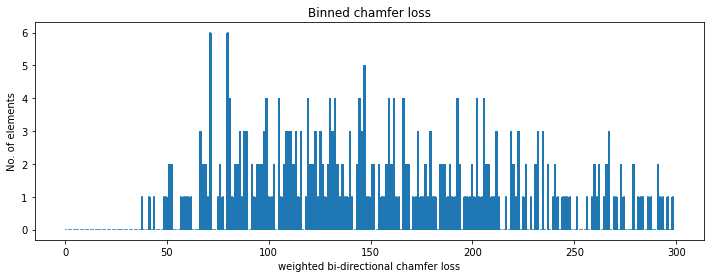

In [52]:
dists = chamfer_evaluate(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)
# if inference:
#     with open(model_path + 'preds_' + cat + '.pkl', 'wb') as f:
#         pickle.dump([predictions_list, id_list, dists], f)
    
plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [29]:
# scaling up and down is required for icp calculations
def _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size,
                     threshold, icp_correction = False):

    preds_list, pcd_list = [], []
    viewer_list, ifc_list = [], []
    error_count = 0

    # get predictions and pcds
    #for i in tqdm(range(len(predictions_list))):
    for i in tqdm(range(50)):
        pcd_id = id_list[i].item()
        pcd, preds = cloud_list[i].transpose(1, 0).tolist(), copy.deepcopy(predictions_list[i])
        #print(preds, inputs_list[i])

        preds = scale_preds(preds.tolist(), cat)
        print(preds)
        #pcd, preds = prepare_visualisation(pcd_id, cat, i, cloud_list, inputs_list, ext)

#         try:
        if  icp_correction:
            # note: preds are updated in place during ICP
            viewer, ifc = icp_finetuning(o3d.utility.Vector3dVector(pcd), pcd_id, cat, preds, blueprint, temp_dir, target_dir, 
                                 ifcConvert_executable, cloudCompare_executable, sample_size, threshold, True)
        else:
            #print(preds)
            viewer, ifc = visualize_predictions([pcd], cat, [preds], blueprint, visualize=True)


        preds_list.append(preds)
        pcd_list.append(pcd)
        viewer_list.append(viewer)
        ifc_list.append(ifc)

#         except Exception as e:
#             print("ICP error", pcd_id, e)
#             error_count += 1


    print("error_count", error_count)    
    return viewer_list

In [30]:
viewers = _visualise_predictions(predictions_list, cloud_list, id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

  0%|          | 0/50 [00:00<?, ?it/s]

[175.40223896503448, 1246.2360858917236, 0.028984030708670616, -0.16263094544410706, -0.11660069972276688, -0.11862680315971375, 0.9962579607963562, -0.29660487174987793, 0.6688725352287292, 0.3999951481819153, 0.836162805557251]
[-12.077957391738892, 1641.0399675369263, -6.454135291278362e-05, 1.6765901818871498e-05, -0.09731519967317581, 0.016250861808657646, 0.859279990196228, -0.0811065137386322, 0.875777006149292, 0.6247588992118835, 0.6933841109275818]


RuntimeError: Failed to process shape

In [ ]:
for v in viewers:
    print(v)

In [ ]:
plot_parameter_errors(inputs_list, predictions_list, cat)

#### BP data Visualisation

In [ ]:
batch_visualise(model_path, blueprint, path, ext, device, ifc=False)

In [ ]:
merge_clouds(path, 'pipe')

### fine tuning

In [13]:
print(len(predictions_list))

345


In [53]:
#limit = 100
limit = len(predictions_list)
torch.autograd.set_detect_anomaly(False)
print(cat)
if cat == 'bend':
    cat = 'elbow'
modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=False, elbow_fix=True)
#cl_v, v, modified_preds = chamfer_fine_tune(100, 0.01, predictions_list[:limit], cloud_list[:limit], cat, blueprint, alpha=3, visualise=True)

       

elbow


  0%|          | 0/100 [00:00<?, ?it/s]

0 loss 376.51724
1 loss 338.35825
2 loss 308.89273
3 loss 286.25433
4 loss 268.59665
5 loss 254.42027
6 loss 242.79814
7 loss 233.09021
8 loss 224.7778
9 loss 217.49268
10 loss 211.02252
11 loss 205.15707
12 loss 199.54411
13 loss 194.20947
14 loss 189.52196
15 loss 185.15457
16 loss 180.96793
17 loss 177.17168
18 loss 173.72285
19 loss 170.426
20 loss 167.40239
21 loss 164.11984
22 loss 161.30081
23 loss 158.57425
24 loss 157.56728
25 loss 154.85764
26 loss 151.03311
27 loss 148.73276
28 loss 146.59082
29 loss 144.53194
30 loss 144.93187
31 loss 143.03656
32 loss 138.94212
33 loss 137.29037
34 loss 135.6232
35 loss 135.08788
36 loss 133.31302
37 loss 131.9118
38 loss 129.50098
39 loss 128.50417
40 loss 126.8486
41 loss 125.64363
42 loss 125.386986
43 loss 124.04884
44 loss 123.23063
45 loss 121.262794
46 loss 121.632385
47 loss 120.745514
48 loss 119.07148
49 loss 118.29614
50 loss 116.18523
51 loss 115.28376
52 loss 127.50069
53 loss 113.634705
54 loss 112.64462
55 loss 111.64187
56 

  0%|          | 0/345 [00:00<?, ?it/s]

err 33


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 745.883
1 loss 624.681
2 loss 527.9801
3 loss 450.99182
4 loss 389.35056
5 loss 340.71887
6 loss 301.6794
7 loss 270.52875
8 loss 246.56668
9 loss 228.80453
10 loss 215.9562
11 loss 209.3783
12 loss 203.09882
13 loss 197.94408
14 loss 193.49524
15 loss 190.92603
16 loss 187.59552
17 loss 186.00288
18 loss 183.34982
19 loss 185.16396
20 loss 179.70215
21 loss 172.3748
22 loss 166.74252
23 loss 162.50119
24 loss 161.00414
25 loss 156.5904
26 loss 152.8148
27 loss 148.2355
28 loss 145.85168
29 loss 145.6613
30 loss 141.92067
31 loss 139.7869
32 loss 137.86502
33 loss 135.48877
34 loss 131.7096
35 loss 129.50531
36 loss 131.72827
37 loss 132.71465
38 loss 128.5232
39 loss 126.454994
40 loss 124.12427
41 loss 125.07829
42 loss 127.4706
43 loss 122.25518
44 loss 122.10391
45 loss 119.416565
46 loss 118.58629
47 loss 119.40047
48 loss 118.507706
49 loss 119.92514


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 733.964
1 loss 608.35913
2 loss 513.3535
3 loss 438.93982
4 loss 381.42447
5 loss 333.7187
6 loss 298.1715
7 loss 270.45728
8 loss 248.82431
9 loss 231.75772
10 loss 217.93402
11 loss 206.8988
12 loss 200.52248
13 loss 195.11993
14 loss 189.92935
15 loss 186.32442
16 loss 185.0597
17 loss 181.93152
18 loss 179.36092
19 loss 175.854
20 loss 172.27844
21 loss 170.16411
22 loss 167.75462
23 loss 161.82036
24 loss 156.33307
25 loss 152.73706
26 loss 149.82059
27 loss 148.94159
28 loss 145.44495
29 loss 144.9104
30 loss 151.70964
31 loss 149.81686
32 loss 146.71338
33 loss 143.53116
34 loss 142.72415
35 loss 138.09189
36 loss 136.96408
37 loss 136.3743
38 loss 135.09392
39 loss 134.95197
40 loss 133.0658
41 loss 139.46066
42 loss 138.17412
43 loss 136.07106
44 loss 129.759
45 loss 128.94662
46 loss 127.93285
47 loss 132.34805
48 loss 135.28642
49 loss 130.05934


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 763.38153
1 loss 627.5342
2 loss 521.11523
3 loss 439.71008
4 loss 373.8511
5 loss 320.59656
6 loss 278.3813
7 loss 247.60268
8 loss 227.19376
9 loss 214.68593
10 loss 207.38855
11 loss 204.01776
12 loss 201.38977
13 loss 199.17148
14 loss 198.93155
15 loss 198.64597
16 loss 198.04494
17 loss 192.4665
18 loss 186.48224
19 loss 182.04614
20 loss 176.08842
21 loss 170.82169
22 loss 166.2603
23 loss 165.6831
24 loss 162.67429
25 loss 161.57101
26 loss 158.4391
27 loss 155.99734
28 loss 150.9006
29 loss 151.99216
30 loss 147.62344
31 loss 149.1777
32 loss 145.60101
33 loss 143.26773
34 loss 140.60123
35 loss 138.94012
36 loss 137.22731
37 loss 134.41663
38 loss 132.22287
39 loss 131.77325
40 loss 130.61624
41 loss 129.09741
42 loss 129.81064
43 loss 127.20658
44 loss 126.80878
45 loss 128.47963
46 loss 124.23755
47 loss 122.78046
48 loss 122.17435
49 loss 121.57213


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 741.551
1 loss 613.37805
2 loss 512.20715
3 loss 432.3568
4 loss 370.71198
5 loss 324.09186
6 loss 288.1717
7 loss 261.2221
8 loss 241.57358
9 loss 226.95529
10 loss 215.9242
11 loss 206.32605
12 loss 198.11914
13 loss 192.88289
14 loss 186.30064
15 loss 183.54684
16 loss 178.71039
17 loss 176.2406
18 loss 170.40134
19 loss 164.08926
20 loss 166.17279
21 loss 162.67946
22 loss 163.35791
23 loss 154.81775
24 loss 152.18971
25 loss 149.57318
26 loss 146.8556
27 loss 147.74174
28 loss 147.39972
29 loss 146.36732
30 loss 142.48618
31 loss 140.89465
32 loss 139.61185
33 loss 137.37871
34 loss 137.93445
35 loss 136.00351
36 loss 133.02362
37 loss 131.63249
38 loss 132.24454
39 loss 130.51959
40 loss 128.20197
41 loss 127.1162
42 loss 126.067276
43 loss 124.59088
44 loss 121.48933
45 loss 120.68907
46 loss 120.378395
47 loss 119.33152
48 loss 129.62268
49 loss 131.51675


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 370.56165
1 loss 297.49725
2 loss 265.03986
3 loss 241.3735
4 loss 224.1307
5 loss 211.6859
6 loss 202.17538
7 loss 194.94832
8 loss 189.78297
9 loss 184.3266
10 loss 180.0206
11 loss 176.7627
12 loss 175.1797
13 loss 172.24773
14 loss 173.53857
15 loss 170.90596
16 loss 171.16263
17 loss 171.30061
18 loss 169.19177
19 loss 167.50174
20 loss 165.51556
21 loss 165.2024
22 loss 164.86755
23 loss 164.64499
24 loss 163.31186
25 loss 161.23529
26 loss 160.19685
27 loss 159.42224
28 loss 157.48502
29 loss 156.32135
30 loss 154.9384
31 loss 153.46841
32 loss 151.99446
33 loss 150.2308
34 loss 148.85147
35 loss 147.297
36 loss 149.47194
37 loss 148.31242
38 loss 149.09076
39 loss 146.05934
40 loss 148.17769
41 loss 146.80515
42 loss 150.40378
43 loss 148.45206
44 loss 145.84787
45 loss 145.00644
46 loss 143.23248
47 loss 142.5072
48 loss 140.29056
49 loss 137.67728


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 377.04404
1 loss 303.958
2 loss 272.0692
3 loss 248.70435
4 loss 232.1713
5 loss 220.41891
6 loss 207.73343
7 loss 200.349
8 loss 193.76
9 loss 190.10486
10 loss 186.84177
11 loss 184.40164
12 loss 181.86624
13 loss 185.28575
14 loss 182.40134
15 loss 179.87091
16 loss 177.51071
17 loss 177.37701
18 loss 180.0832
19 loss 181.18654
20 loss 178.3468
21 loss 176.34042
22 loss 176.7237
23 loss 172.50287
24 loss 169.0292
25 loss 168.96619
26 loss 167.68463
27 loss 165.62344
28 loss 165.0372
29 loss 164.39401
30 loss 163.76823
31 loss 164.92567
32 loss 164.1335
33 loss 162.34688
34 loss 160.73218
35 loss 159.67628
36 loss 158.28094
37 loss 155.33879
38 loss 153.94666
39 loss 152.5568
40 loss 151.62381
41 loss 151.20856
42 loss 149.41576
43 loss 147.45064
44 loss 146.92285
45 loss 147.62033
46 loss 146.02808
47 loss 145.14279
48 loss 144.61981
49 loss 145.4093


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 373.92517
1 loss 291.82565
2 loss 268.10013
3 loss 247.11461
4 loss 230.48698
5 loss 219.17729
6 loss 209.91785
7 loss 200.30452
8 loss 193.963
9 loss 188.9361
10 loss 184.62115
11 loss 181.37415
12 loss 178.90895
13 loss 178.48296
14 loss 177.24927
15 loss 175.90698
16 loss 173.893
17 loss 172.79948
18 loss 172.55408
19 loss 170.7751
20 loss 169.08237
21 loss 167.87372
22 loss 170.14902
23 loss 168.54662
24 loss 166.85057
25 loss 165.17694
26 loss 163.3461
27 loss 162.3581
28 loss 160.82574
29 loss 160.35364
30 loss 158.7139
31 loss 157.10526
32 loss 157.76918
33 loss 158.4872
34 loss 158.0776
35 loss 154.38583
36 loss 152.95279
37 loss 152.14026
38 loss 151.74661
39 loss 151.78989
40 loss 150.29752
41 loss 148.28084
42 loss 146.3342
43 loss 145.46283
44 loss 146.20035
45 loss 145.78561
46 loss 145.5488
47 loss 144.71762
48 loss 144.78113
49 loss 143.59534


  0%|          | 0/50 [00:00<?, ?it/s]

0 loss 368.2434
1 loss 292.63226
2 loss 276.15677
3 loss 250.07095
4 loss 230.86076
5 loss 217.35641
6 loss 204.47981
7 loss 198.28467
8 loss 193.35048
9 loss 190.96568
10 loss 190.23994
11 loss 185.90443
12 loss 182.73926
13 loss 178.31436
14 loss 177.52432
15 loss 173.3724
16 loss 170.56667
17 loss 169.58492
18 loss 168.73932
19 loss 167.75955
20 loss 169.98703
21 loss 167.10031
22 loss 165.69302
23 loss 164.51895
24 loss 162.99469
25 loss 161.14171
26 loss 157.93674
27 loss 156.51602
28 loss 155.34123
29 loss 155.77322
30 loss 154.32858
31 loss 152.71603
32 loss 151.71886
33 loss 151.75848
34 loss 151.77478
35 loss 150.5932
36 loss 152.41518
37 loss 150.83096
38 loss 148.7066
39 loss 148.74762
40 loss 147.6113
41 loss 148.18442
42 loss 145.91096
43 loss 144.2762
44 loss 143.72289
45 loss 142.80663
46 loss 142.01788
47 loss 140.34158
48 loss 142.18773
49 loss 141.39635
8
check 33 33
error cloud (2000, 3)


In [16]:
print(len(cl_v), len(v))

NameError: name 'cl_v' is not defined

In [ ]:
print(cl_v)

In [ ]:
#print(modified_preds[0], len(id_list))

In [17]:
plot_parameter_errors(inputs_list, modified_preds, cat)

NameError: name 'inputs_list' is not defined

  0%|          | 0/345 [00:00<?, ?it/s]

error_count 0
avg 57.547607 3 247.00229 2.1553402


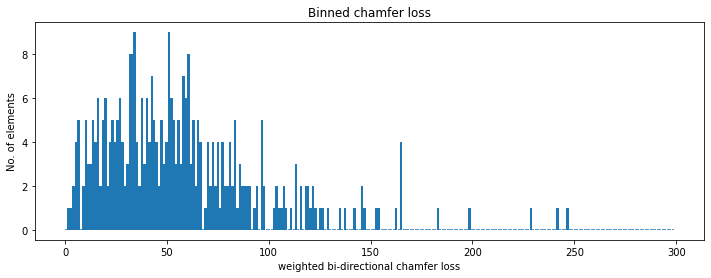

In [55]:
dists = chamfer_evaluate(modified_preds, cloud_list[:limit], id_list, cat, blueprint,  ifcConvert_executable,
                     cloudCompare_executable, temp_dir, target_dir, sample_size, threshold, icp_correction = False)

if inference:
    with open(model_path/('preds_finetuned_' + 'elbow' + '.pkl'), 'wb') as f:
        pickle.dump([modified_preds, id_list, dists], f)

plot_error_graph(dists, "Binned chamfer loss", max_val=300)

In [ ]:
node_dict = get_features_from_params(path)

In [ ]:
preds = torch.tensor([predictions_list[1]]).cuda()
print(predictions_list[1])
pcd = generate_tee_cloud_tensor(preds)
#tee = generate_tee_cloud(predictions_list[0])
tee = pcd[0].cpu().numpy()
tee = o3d.utility.Vector3dVector(tee)
tee_cloud = o3d.geometry.PointCloud()
tee_cloud.points = tee
o3d.io.write_point_cloud("tee_cl.pcd", tee_cloud)


In [ ]:
original = cloud_list[2]
points= o3d.utility.Vector3dVector(original.transpose(1,0))
tee_cloud.points = points
o3d.io.write_point_cloud("tee_cl_inp.pcd", tee_cloud)

In [ ]:
# undo normalisation opf the bp tee dataset created for inference, only for comparison with the inferred tee results
tee_path = 'tee_fix/tee/test/'
metadata_file = open("tee_fix/tee/metadata.json", 'r')
metadata = json.load(metadata_file)
output_path = 'tee_fix/tee/unnormalised/'

files = os.listdir(tee_path)
new_points = []
for f in tqdm(files):
    cloud_data = metadata[f.split(".")[0]]
    points = np.array(o3d.io.read_point_cloud(tee_path + f).points)
    print("a", points[0])
    print(cloud_data["norm_factor"], cloud_data["mean"])
    points *= cloud_data["norm_factor"]
    print("b", points[0])

    for i, pnt in enumerate(points):
        pnt += cloud_data["mean"]
    print("c", points[10])
    new_points.append(points)
        
new_points = o3d.utility.Vector3dVector(np.concatenate(new_points))
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud(output_path+"tee_bp_unnormalised.pcd", new_cloud)

## Mesh deformation

In [ ]:
pr = [0.5,1.0, 0.2, 10., 10., 10., math.sin(0.75), math.cos(0.75), math.sin(0.75), math.cos(0.75), math.sin(0.75), math.cos(0.75)]

pr_tensor = torch.tensor([pr]).cuda()
pcd = generate_flange_cloud_tensor(pr_tensor)
pcd = pcd[0].cpu().numpy()

#pcd = generate_flange_cloud(pr)

print(len(pcd))
new_points = o3d.utility.Vector3dVector(pcd)
new_cloud = o3d.geometry.PointCloud()
new_cloud.points = new_points
o3d.io.write_point_cloud("sample_flange.pcd", new_cloud)

